# Preprocessing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

here we load the dataset, note that Pnode refers to the pressure at the node while dnode refers to its demand. Also, label 0 indicates no leak while label 1 indicates leak.
The loaded dataset file presents a compiled version of LeakDB dataset and presenting the combination of 1000 csv files, each csv is 1 year time series simulation of water distribution network with half an hour time step. therefore, given the large size of the compiled dataset, we used parquet library given its ability of reducing the large size. eventually the compiled dataset mounted up to 17 million datapoints.

In [2]:
%%time
# Define the file path
file_path = r'C:\Users\qaboshama\Desktop\ANFIS\data_replicated_updated_5.parquet'

# Load the Parquet file into a DataFrame
df = pd.read_parquet(file_path)

# Display the first few rows of the DataFrame
df.head()


CPU times: total: 30 s
Wall time: 2.75 s


,Index,Timestamp,scenario,PNode_2,PNode_9,PNode_10,PNode_11,PNode_12,PNode_13,PNode_21,...,dNode_10,dNode_11,dNode_12,dNode_13,dNode_21,dNode_22,dNode_23,dNode_31,dNode_32,Label
0,1,1/1/2017 0:00,1,36.576,0.0,92.944,89.658,82.317,83.756,84.905,...,0.0,18.0,21.6,14.4,18.0,28.8,18.0,18.0,10.8,0.0
1,2,1/1/2017 0:30,1,37.265,0.0,93.525,90.288,83.008,84.478,85.796,...,0.0,18.0,18.0,10.8,18.0,28.8,14.4,14.4,10.8,0.0
2,3,1/1/2017 1:00,1,37.985,0.0,94.188,91.007,83.731,85.228,86.611,...,0.0,14.4,14.4,10.8,18.0,25.2,14.4,14.4,10.8,0.0
3,4,1/1/2017 1:30,1,38.741,0.0,94.841,91.715,84.487,85.989,87.385,...,0.0,10.8,14.4,10.8,14.4,25.2,10.8,14.4,7.2,0.0
4,5,1/1/2017 2:00,1,39.505,0.0,95.488,92.417,85.252,86.766,88.313,...,0.0,10.8,10.8,7.2,14.4,21.6,10.8,10.8,7.2,0.0


In [3]:
df.columns

Index(['Index', 'Timestamp', 'scenario', 'PNode_2', 'PNode_9', 'PNode_10',
       'PNode_11', 'PNode_12', 'PNode_13', 'PNode_21', 'PNode_22', 'PNode_23',
       'PNode_31', 'PNode_32', 'dNode_2', 'dNode_9', 'dNode_10', 'dNode_11',
       'dNode_12', 'dNode_13', 'dNode_21', 'dNode_22', 'dNode_23', 'dNode_31',
       'dNode_32', 'Label'],
      dtype='object')

## *Feature selection*

in this model we exclusively deploy pressure features and disregard other features like flow or demand. for more explanation, please refer to our paper. 

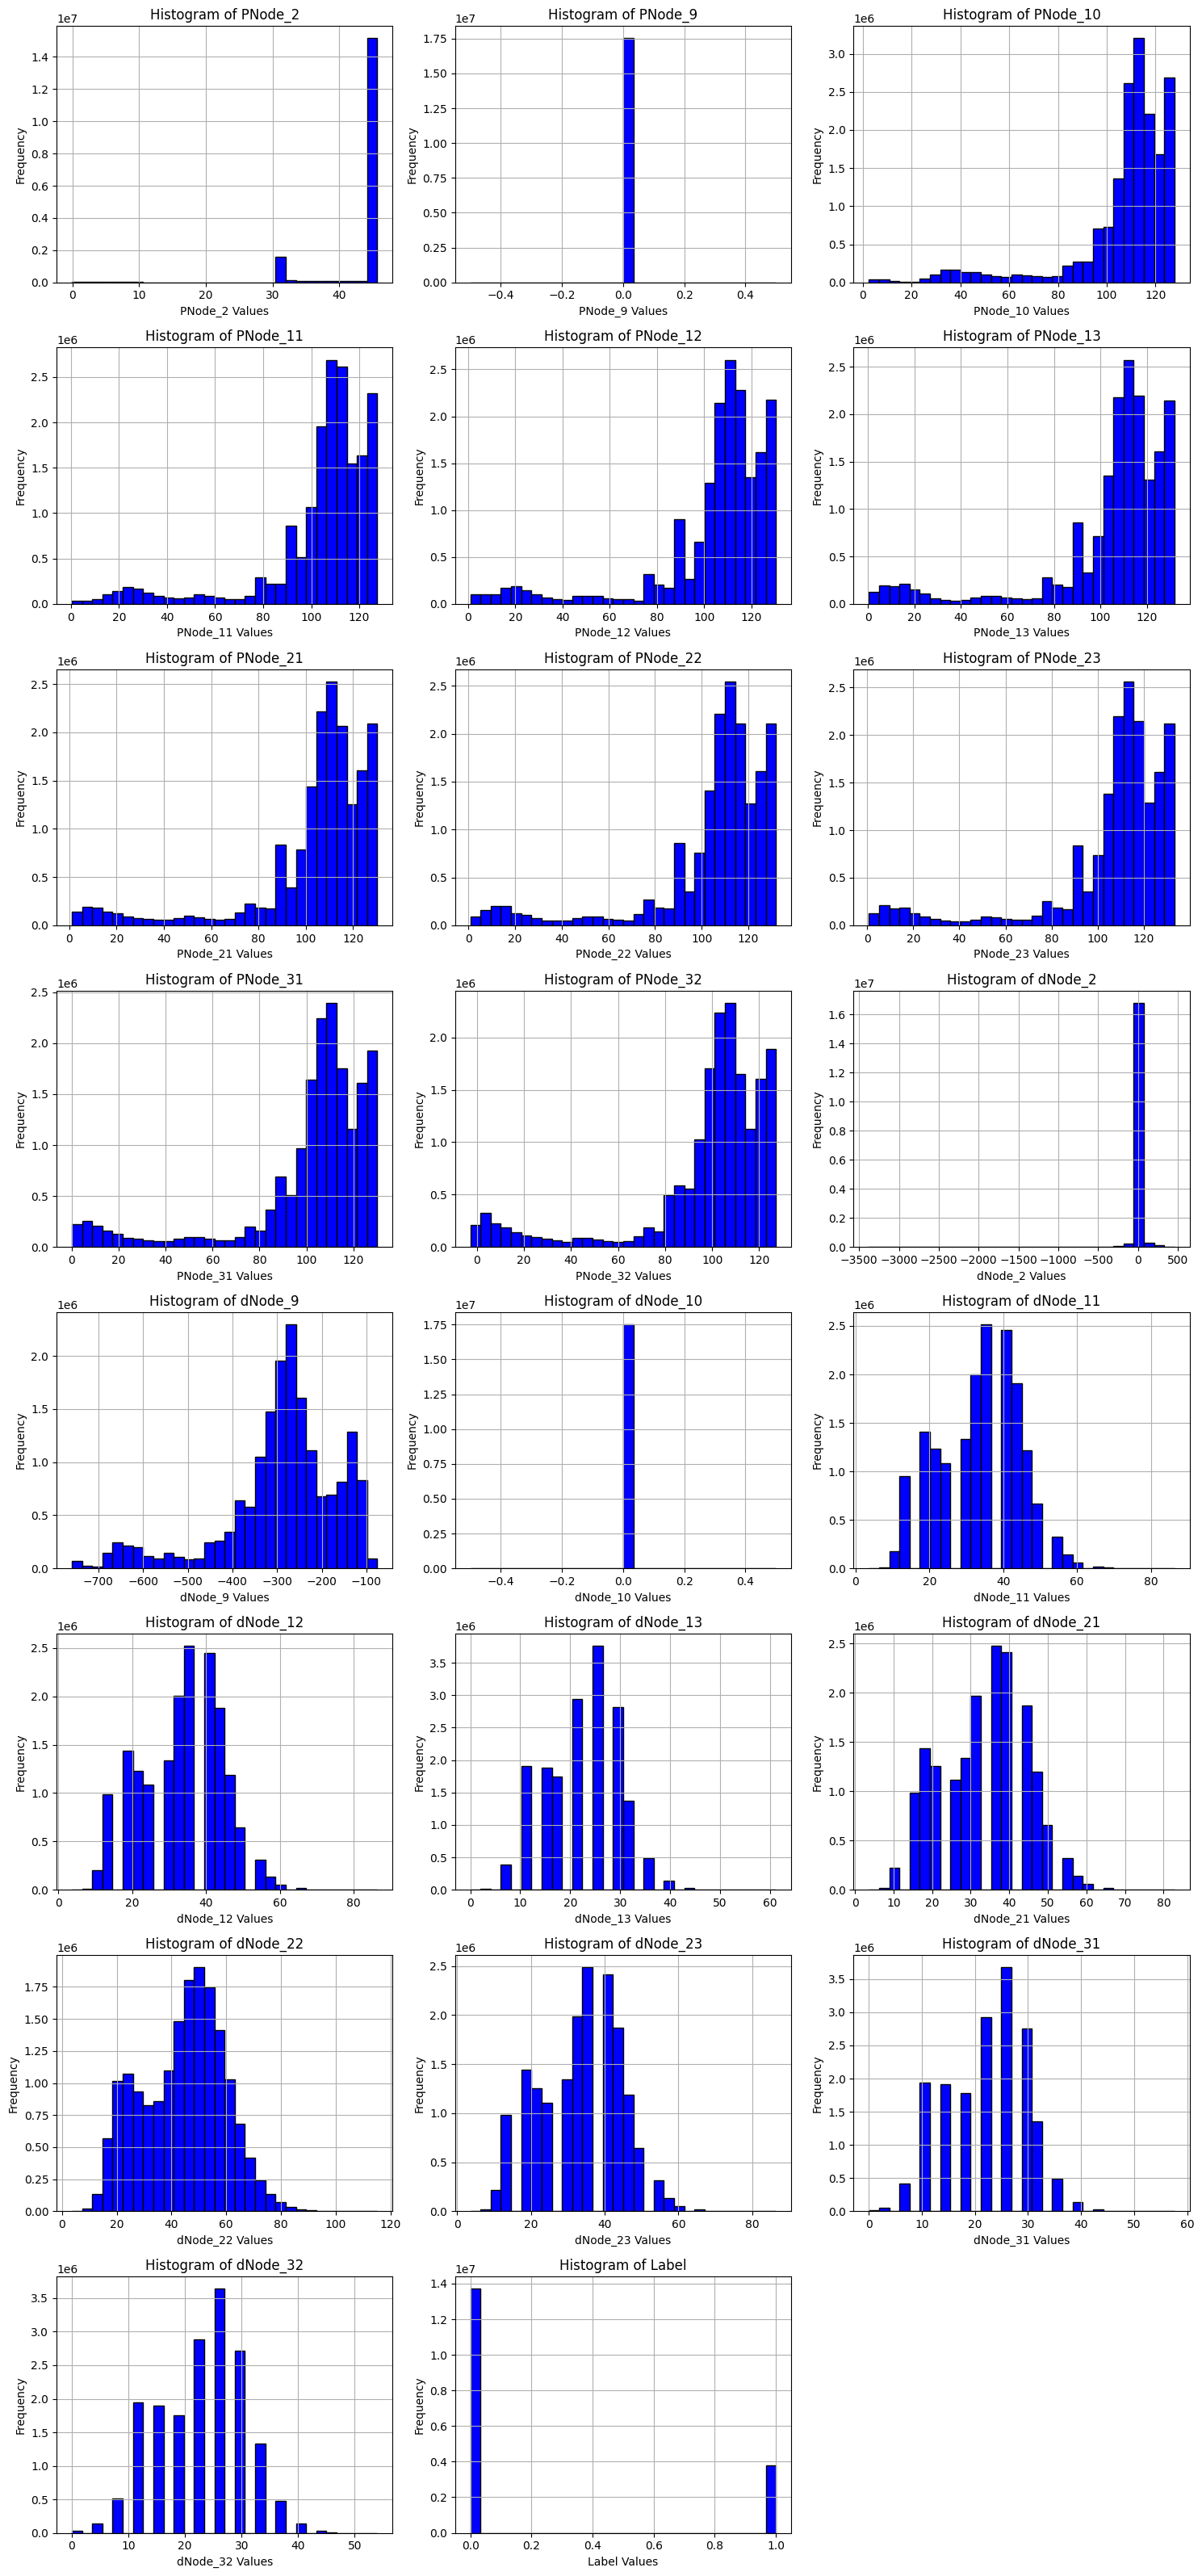

In [7]:
# feature visualization
# List of columns to exclude
exclude_columns = ['Index', 'Timestamp', 'scenario']

# Filter columns to plot
columns_to_plot = [col for col in df.columns if col not in exclude_columns]

# Number of columns for the subplot grid
n_cols = 3
n_rows = math.ceil(len(columns_to_plot) / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()  # Flatten the 2D array of axes for easy indexing

# Plot each histogram
for i, column in enumerate(columns_to_plot):
    axes[i].hist(df[column], bins=30, color='blue', edgecolor='black')
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(f'{column} Values')
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [13]:
# remove the following features data frame since they are empty, 
# removing the demand is based on the intent of only modelling pressure data
"""
(Index', 'scenario', 'PNode_9', 'dNode_2', 'dNode_9', 'dNode_10', 'dNode_11',
       'dNode_12', 'dNode_13', 'dNode_21', 'dNode_22', 'dNode_23', 'dNode_31',
       'dNode_32'
"""

"\n(Index', 'scenario', 'PNode_9', 'dNode_2', 'dNode_9', 'dNode_10', 'dNode_11',\n       'dNode_12', 'dNode_13', 'dNode_21', 'dNode_22', 'dNode_23', 'dNode_31',\n       'dNode_32'\n"

In [8]:
# List of columns to remove
columns_to_remove = [
    'Index', 'scenario', 'PNode_9',
    'dNode_2', 'dNode_9', 'dNode_10', 'dNode_11',
    'dNode_12', 'dNode_13', 'dNode_21', 'dNode_22', 'dNode_23', 'dNode_31',
    'dNode_32'
]

# Drop the specified columns
df= df.drop(columns=columns_to_remove)

# Optionally, display the first few rows of the cleaned DataFrame to verify
df.head()


,Timestamp,PNode_2,PNode_10,PNode_11,PNode_12,PNode_13,PNode_21,PNode_22,PNode_23,PNode_31,PNode_32,Label
0,1/1/2017 0:00,36.576,92.944,89.658,82.317,83.756,84.905,83.847,85.278,83.177,79.205,0.0
1,1/1/2017 0:30,37.265,93.525,90.288,83.008,84.478,85.796,84.558,86.003,84.222,79.952,0.0
2,1/1/2017 1:00,37.985,94.188,91.007,83.731,85.228,86.611,85.311,86.759,85.148,80.731,0.0
3,1/1/2017 1:30,38.741,94.841,91.715,84.487,85.989,87.385,86.073,87.523,85.873,81.500,0.0
4,1/1/2017 2:00,39.505,95.488,92.417,85.252,86.766,88.313,86.856,88.304,86.937,82.286,0.0


In [9]:
# remove timestamp
df = df.drop(columns='Timestamp')
df.head()

,PNode_2,PNode_10,PNode_11,PNode_12,PNode_13,PNode_21,PNode_22,PNode_23,PNode_31,PNode_32,Label
0,36.576,92.944,89.658,82.317,83.756,84.905,83.847,85.278,83.177,79.205,0.0
1,37.265,93.525,90.288,83.008,84.478,85.796,84.558,86.003,84.222,79.952,0.0
2,37.985,94.188,91.007,83.731,85.228,86.611,85.311,86.759,85.148,80.731,0.0
3,38.741,94.841,91.715,84.487,85.989,87.385,86.073,87.523,85.873,81.500,0.0
4,39.505,95.488,92.417,85.252,86.766,88.313,86.856,88.304,86.937,82.286,0.0


## *Feature extraction*

next we  use rolling window statistics for feature extraction, the window is composed of 48 points with overlapping of 24 points
in each window we extract the following from each feature:
mean, std, min, max, rate of change, autocorrelation, rolling mean

perform this for all features except Label
since the Label is the target feature and it is needed for binary classification task, perform majority label on each window (0 or 1)


In [19]:
# remark:  rolling mean and mean are the same thing, we will remove the rolling mean at a later stage
from scipy.stats import pearsonr
import warnings
import time

# Define rolling window parameters
window_size = 48
overlap = 24
step_size = window_size - overlap

# Convert DataFrame to NumPy arrays
print("Converting DataFrame to NumPy arrays...")
start_time = time.time()
df_values = df.to_numpy()
labels = df['Label'].to_numpy()
feature_names = df.columns[df.columns != 'Label']
print(f"Conversion completed in {time.time() - start_time:.2f} seconds")

# Define a function to calculate autocorrelation with constant input handling
def autocorrelation(series):
    if len(series) <= 1 or np.unique(series).size == 1:
        return np.nan
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        try:
            return pearsonr(series[:-1], series[1:])[0]
        except:
            return np.nan

# Define a function to calculate rate of change
def rate_of_change(series):
    return (series[-1] - series[0]) / series[0] if series[0] != 0 else np.nan

# Prepare lists to collect feature data
all_features = []
all_labels = []

# Loop through each feature for rolling window extraction
for feature_idx, feature_name in enumerate(feature_names):
    print(f"Processing feature: {feature_name}...")
    start_time = time.time()
    feature_data = []
    for start in range(0, len(df_values) - window_size + 1, step_size):
        end = start + window_size
        window = df_values[start:end, feature_idx]

        mean = np.mean(window)
        std = np.std(window)
        min_val = np.min(window)
        max_val = np.max(window)
        roc = rate_of_change(window)
        ac = autocorrelation(window)
        rolling_mean = np.mean(window)  # Rolling mean is just mean in this case

        feature_data.append([mean, std, min_val, max_val, roc, ac, rolling_mean])

    # Convert list to NumPy array and then to DataFrame
    feature_df = pd.DataFrame(feature_data, columns=[f'{feature_name}_mean', f'{feature_name}_std', f'{feature_name}_min', f'{feature_name}_max', f'{feature_name}_rate_of_change', f'{feature_name}_autocorrelation', f'{feature_name}_rolling_mean'])
    all_features.append(feature_df)
    print(f"Feature {feature_name} processed in {time.time() - start_time:.2f} seconds")

# Concatenate all features into a single DataFrame
print("Concatenating all features into a single DataFrame...")
start_time = time.time()
features_df = pd.concat(all_features, axis=1)
print(f"Concatenation completed in {time.time() - start_time:.2f} seconds")

# Compute the majority label for each rolling window
def majority_label(series):
    return np.nan if len(series) == 0 else pd.Series(series).mode().iloc[0]

print("Computing majority labels for each rolling window...")
start_time = time.time()
labels_data = []
for start in range(0, len(df_values) - window_size + 1, step_size):
    end = start + window_size
    window_labels = labels[start:end]
    labels_data.append(majority_label(window_labels))
labels_df = pd.DataFrame(labels_data, columns=['Label'])
print(f"Label computation completed in {time.time() - start_time:.2f} seconds")

# Concatenate the features and labels
print("Concatenating features and labels into the final DataFrame...")
start_time = time.time()
final_df = pd.concat([features_df, labels_df], axis=1)
final_df.reset_index(drop=True, inplace=True)
print(f"Final DataFrame concatenation completed in {time.time() - start_time:.2f} seconds")

# Display the first few rows of the final DataFrame
print("Displaying the first few rows of the final DataFrame...")
print(final_df.head())


Converting DataFrame to NumPy arrays...
Conversion completed in 0.00 seconds
Processing feature: PNode_2...
Feature PNode_2 processed in 290.56 seconds
Processing feature: PNode_10...
Feature PNode_10 processed in 861.22 seconds
Processing feature: PNode_11...
Feature PNode_11 processed in 846.61 seconds
Processing feature: PNode_12...
Feature PNode_12 processed in 845.65 seconds
Processing feature: PNode_13...
Feature PNode_13 processed in 845.28 seconds
Processing feature: PNode_21...
Feature PNode_21 processed in 845.71 seconds
Processing feature: PNode_22...
Feature PNode_22 processed in 845.90 seconds
Processing feature: PNode_23...
Feature PNode_23 processed in 846.10 seconds
Processing feature: PNode_31...
Feature PNode_31 processed in 845.47 seconds
Processing feature: PNode_32...
Feature PNode_32 processed in 846.47 seconds
Concatenating all features into a single DataFrame...
Concatenation completed in 0.13 seconds
Computing majority labels for each rolling window...
Label co

In [23]:
df.shape

(17520000, 11)

In [22]:
final_df.shape

(729999, 71)

In [53]:
final_df.head()

,PNode_2_mean,PNode_2_std,PNode_2_min,PNode_2_max,PNode_2_rate_of_change,PNode_2_autocorrelation,PNode_10_mean,PNode_10_std,PNode_10_min,PNode_10_max,...,PNode_31_max,PNode_31_rate_of_change,PNode_31_autocorrelation,PNode_32_mean,PNode_32_std,PNode_32_min,PNode_32_max,PNode_32_rate_of_change,PNode_32_autocorrelation,Label
0,44.440146,2.539537,36.576,45.72,0.25,0.997746,108.753438,8.666907,92.944,121.994,...,121.388,0.459394,0.940909,99.987896,11.559922,79.205,118.370,0.494476,0.944750,0.0
1,45.720000,0.000000,45.720,45.72,0.00,0.000000,117.341687,5.620857,108.667,126.909,...,128.652,0.017077,0.974053,111.765146,8.062942,99.235,125.648,0.017660,0.974092,0.0
2,45.720000,0.000000,45.720,45.72,0.00,0.000000,117.163417,5.666159,108.667,126.909,...,128.652,-0.011827,0.972997,111.524875,8.127138,99.235,125.648,-0.012066,0.973082,0.0
3,45.720000,0.000000,45.720,45.72,0.00,0.000000,117.088125,5.735075,108.347,127.012,...,128.823,-0.000985,0.971228,111.401687,8.255815,98.907,125.820,-0.001466,0.971254,0.0
4,45.720000,0.000000,45.720,45.72,0.00,0.000000,116.861583,5.731298,108.347,127.012,...,128.823,-0.019070,0.977288,111.074583,8.248309,98.907,125.820,-0.019075,0.977311,0.0


In [26]:
# List the feature names (excluding the 'Label' column if present)
feature_names = [col for col in final_df.columns if col != 'Label']

# Display the feature names
print(f"Number of features: {len(feature_names)}")
print("Feature names:")
for name in feature_names:
    print(name)


Number of features: 70
Feature names:
PNode_2_mean
PNode_2_std
PNode_2_min
PNode_2_max
PNode_2_rate_of_change
PNode_2_autocorrelation
PNode_2_rolling_mean
PNode_10_mean
PNode_10_std
PNode_10_min
PNode_10_max
PNode_10_rate_of_change
PNode_10_autocorrelation
PNode_10_rolling_mean
PNode_11_mean
PNode_11_std
PNode_11_min
PNode_11_max
PNode_11_rate_of_change
PNode_11_autocorrelation
PNode_11_rolling_mean
PNode_12_mean
PNode_12_std
PNode_12_min
PNode_12_max
PNode_12_rate_of_change
PNode_12_autocorrelation
PNode_12_rolling_mean
PNode_13_mean
PNode_13_std
PNode_13_min
PNode_13_max
PNode_13_rate_of_change
PNode_13_autocorrelation
PNode_13_rolling_mean
PNode_21_mean
PNode_21_std
PNode_21_min
PNode_21_max
PNode_21_rate_of_change
PNode_21_autocorrelation
PNode_21_rolling_mean
PNode_22_mean
PNode_22_std
PNode_22_min
PNode_22_max
PNode_22_rate_of_change
PNode_22_autocorrelation
PNode_22_rolling_mean
PNode_23_mean
PNode_23_std
PNode_23_min
PNode_23_max
PNode_23_rate_of_change
PNode_23_autocorrelation

In [27]:
# Check which features have NaN values
nan_columns = final_df.columns[final_df.isna().any()].tolist()

# Display features with NaN values
print(f"Features with NaN values: {nan_columns}")


Features with NaN values: ['PNode_2_autocorrelation']


In [28]:
# Replace NaN values in 'PNode_2_autocorrelation' with 0
final_df['PNode_2_autocorrelation'].fillna(0, inplace=True)

# Verify the replacement
print(final_df['PNode_2_autocorrelation'].head())


0    0.997746
1    0.000000
2    0.000000
3    0.000000
4    0.000000
Name: PNode_2_autocorrelation, dtype: float64


C:\Users\qaboshama\AppData\Local\Temp\2\ipykernel_720\3974640732.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_df['PNode_2_autocorrelation'].fillna(0, inplace=True)


In [29]:
# Check which features have NaN values
nan_columns = final_df.columns[final_df.isna().any()].tolist()

# Display features with NaN values
print(f"Features with NaN values: {nan_columns}")


Features with NaN values: []


In [39]:
# remove redundant rolling mean
# Remove rolling mean features from the dataframe
columns_to_drop = [col for col in final_df.columns if '_rolling_mean' in col]
final_df_cleaned = final_df.drop(columns=columns_to_drop)

print(f"Removed {len(columns_to_drop)} rolling mean columns.")
print("Remaining features:")
print(final_df_cleaned.columns)

# Display the first few rows of the cleaned dataframe
print("Displaying the first few rows of the cleaned DataFrame:")
final_df_cleaned.head()


Removed 10 rolling mean columns.
Remaining features:
Index(['PNode_2_mean', 'PNode_2_std', 'PNode_2_min', 'PNode_2_max',
       'PNode_2_rate_of_change', 'PNode_2_autocorrelation', 'PNode_10_mean',
       'PNode_10_std', 'PNode_10_min', 'PNode_10_max',
       'PNode_10_rate_of_change', 'PNode_10_autocorrelation', 'PNode_11_mean',
       'PNode_11_std', 'PNode_11_min', 'PNode_11_max',
       'PNode_11_rate_of_change', 'PNode_11_autocorrelation', 'PNode_12_mean',
       'PNode_12_std', 'PNode_12_min', 'PNode_12_max',
       'PNode_12_rate_of_change', 'PNode_12_autocorrelation', 'PNode_13_mean',
       'PNode_13_std', 'PNode_13_min', 'PNode_13_max',
       'PNode_13_rate_of_change', 'PNode_13_autocorrelation', 'PNode_21_mean',
       'PNode_21_std', 'PNode_21_min', 'PNode_21_max',
       'PNode_21_rate_of_change', 'PNode_21_autocorrelation', 'PNode_22_mean',
       'PNode_22_std', 'PNode_22_min', 'PNode_22_max',
       'PNode_22_rate_of_change', 'PNode_22_autocorrelation', 'PNode_23_mean'

,PNode_2_mean,PNode_2_std,PNode_2_min,PNode_2_max,PNode_2_rate_of_change,PNode_2_autocorrelation,PNode_10_mean,PNode_10_std,PNode_10_min,PNode_10_max,...,PNode_31_max,PNode_31_rate_of_change,PNode_31_autocorrelation,PNode_32_mean,PNode_32_std,PNode_32_min,PNode_32_max,PNode_32_rate_of_change,PNode_32_autocorrelation,Label
0,44.440146,2.539537,36.576,45.72,0.25,0.997746,108.753438,8.666907,92.944,121.994,...,121.388,0.459394,0.940909,99.987896,11.559922,79.205,118.370,0.494476,0.944750,0.0
1,45.720000,0.000000,45.720,45.72,0.00,0.000000,117.341687,5.620857,108.667,126.909,...,128.652,0.017077,0.974053,111.765146,8.062942,99.235,125.648,0.017660,0.974092,0.0
2,45.720000,0.000000,45.720,45.72,0.00,0.000000,117.163417,5.666159,108.667,126.909,...,128.652,-0.011827,0.972997,111.524875,8.127138,99.235,125.648,-0.012066,0.973082,0.0
3,45.720000,0.000000,45.720,45.72,0.00,0.000000,117.088125,5.735075,108.347,127.012,...,128.823,-0.000985,0.971228,111.401687,8.255815,98.907,125.820,-0.001466,0.971254,0.0
4,45.720000,0.000000,45.720,45.72,0.00,0.000000,116.861583,5.731298,108.347,127.012,...,128.823,-0.019070,0.977288,111.074583,8.248309,98.907,125.820,-0.019075,0.977311,0.0


In [41]:
final_df = final_df_cleaned
final_df.shape

(729999, 61)

In [42]:
final_df.to_csv('df_features_extracted.csv', index=False)

## *Feature importance*

In [44]:
# split into X and y
X = final_df.drop(columns=['Label'])  # Features (all columns except 'Label')
y = final_df['Label']  # Target (Label)

In [45]:
# splitting into training and testing
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [46]:
# Initialize and fit the Random Forest model
rf = RandomForestClassifier(n_estimators=50, random_state=42, verbose=2)
rf.fit(X_train, y_train)

building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  7.5min


building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


RandomForestClassifier(n_estimators=50, random_state=42, verbose=2)

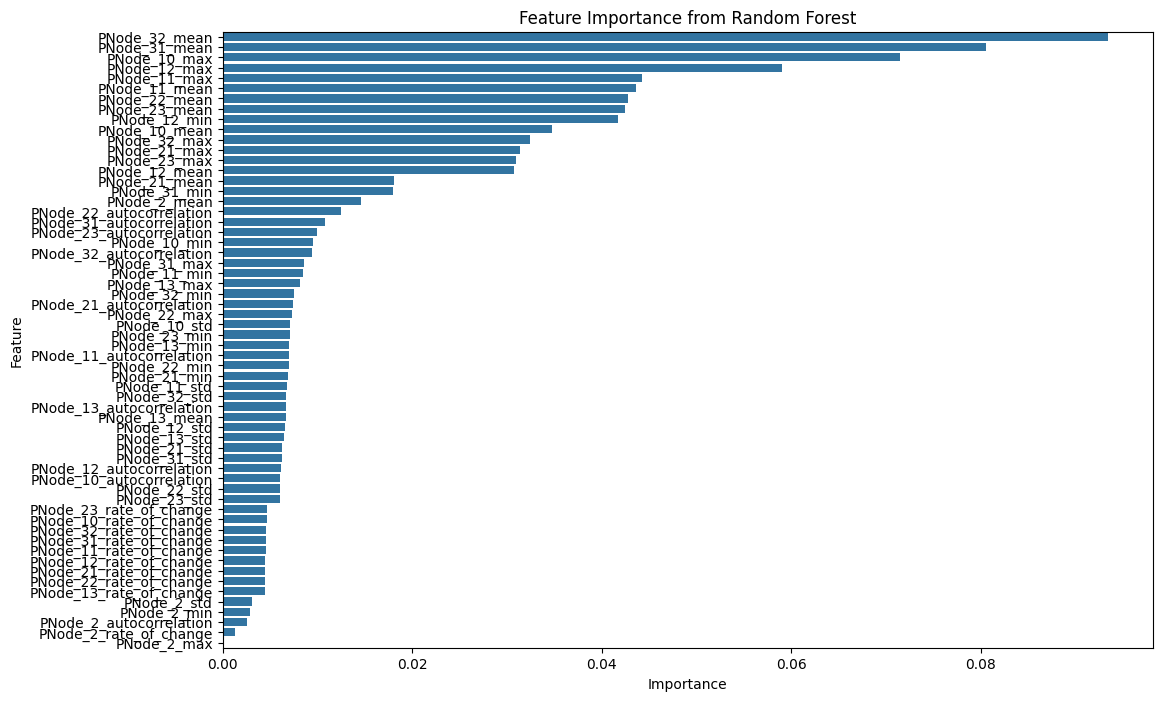

In [47]:
# Get feature importances
importances = rf.feature_importances_

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importance from Random Forest')
plt.show()


In [48]:
# Get feature importances from the random forest model
importances = rf.feature_importances_

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display feature importances in tabular format
print("Feature Importances:")
print(feature_importances.to_string(index=False))  # Print without row indices for better readability

# Optionally save the table to a CSV file
feature_importances.to_csv('feature_importances.csv', index=False)


Feature Importances:
                 Feature  Importance
           PNode_32_mean    0.093488
           PNode_31_mean    0.080620
            PNode_10_max    0.071474
            PNode_12_max    0.059033
            PNode_11_max    0.044250
           PNode_11_mean    0.043582
           PNode_22_mean    0.042788
           PNode_23_mean    0.042480
            PNode_12_min    0.041779
           PNode_10_mean    0.034786
            PNode_32_max    0.032429
            PNode_21_max    0.031387
            PNode_23_max    0.031001
           PNode_12_mean    0.030766
           PNode_21_mean    0.018108
            PNode_31_min    0.018000
            PNode_2_mean    0.014619
PNode_22_autocorrelation    0.012528
PNode_31_autocorrelation    0.010801
PNode_23_autocorrelation    0.010001
            PNode_10_min    0.009486
PNode_32_autocorrelation    0.009477
            PNode_31_max    0.008605
            PNode_11_min    0.008529
            PNode_13_max    0.008167
            PNode

## *Feature selection with mutual information*

In [50]:
# since i aim towards interpretability i will remove features based on mutual information
from sklearn.feature_selection import mutual_info_classif

# Split features and label
X = final_df.drop(columns=['Label'])  # Features (all columns except 'Label')
y = final_df['Label']  # Target (Label)

# Step 1: Compute mutual information
mi_scores = mutual_info_classif(X, y, random_state=42)

# Convert the scores into a DataFrame for better visualization
mi_df = pd.DataFrame({'Feature': X.columns, 'MI_Score': mi_scores})
mi_df = mi_df.sort_values(by='MI_Score', ascending=False)

# Step 2: Select top 10 features
top_10_features = mi_df['Feature'].head(10).tolist()

print("Top 10 features based on mutual information:")
print(top_10_features)

# Step 3: Create a new DataFrame with these top 10 features
X_top10 = X[top_10_features]

# Optionally, you can now split the data again for training and testing with the selected features


Top 10 features based on mutual information:
['PNode_2_max', 'PNode_2_mean', 'PNode_2_min', 'PNode_10_mean', 'PNode_32_mean', 'PNode_31_mean', 'PNode_23_mean', 'PNode_12_mean', 'PNode_13_mean', 'PNode_22_mean']


In [54]:

# Assuming 'final_df' is your original DataFrame and 'top_10_features' contains the selected features
# Create a new DataFrame with these top 10 features and the Label column
df_10features_extracted = final_df[['Label'] + top_10_features]

# Save the DataFrame as a CSV file
df_10features_extracted.to_csv('df_10features_extracted.csv', index=False)

print("DataFrame with top 10 features and labels saved as 'df_10features_extracted.csv'.")


DataFrame with top 10 features and labels saved as 'df_10features_extracted.csv'.


In [55]:
df_10features_extracted.shape

(729999, 11)

## *Mutual information visualization*


In [9]:
%%time
# Define the file path
file_path = r'C:\Users\qaboshama\Desktop\ANFIS\df_features_extracted.csv'

# Load the Parquet file into a DataFrame
df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
df.head()


CPU times: total: 6.77 s
Wall time: 6.79 s


,PNode_2_mean,PNode_2_std,PNode_2_min,PNode_2_max,PNode_2_rate_of_change,PNode_2_autocorrelation,PNode_10_mean,PNode_10_std,PNode_10_min,PNode_10_max,...,PNode_31_max,PNode_31_rate_of_change,PNode_31_autocorrelation,PNode_32_mean,PNode_32_std,PNode_32_min,PNode_32_max,PNode_32_rate_of_change,PNode_32_autocorrelation,Label
0,44.440146,2.539537,36.576,45.72,0.25,0.997746,108.753438,8.666907,92.944,121.994,...,121.388,0.459394,0.940909,99.987896,11.559922,79.205,118.370,0.494476,0.944750,0.0
1,45.720000,0.000000,45.720,45.72,0.00,0.000000,117.341688,5.620857,108.667,126.909,...,128.652,0.017077,0.974053,111.765146,8.062942,99.235,125.648,0.017660,0.974092,0.0
2,45.720000,0.000000,45.720,45.72,0.00,0.000000,117.163417,5.666159,108.667,126.909,...,128.652,-0.011827,0.972997,111.524875,8.127138,99.235,125.648,-0.012066,0.973082,0.0
3,45.720000,0.000000,45.720,45.72,0.00,0.000000,117.088125,5.735075,108.347,127.012,...,128.823,-0.000985,0.971228,111.401687,8.255815,98.907,125.820,-0.001466,0.971254,0.0
4,45.720000,0.000000,45.720,45.72,0.00,0.000000,116.861583,5.731298,108.347,127.012,...,128.823,-0.019070,0.977288,111.074583,8.248309,98.907,125.820,-0.019075,0.977311,0.0


In [10]:
# Filter out columns containing 'rate_of_change' or 'autocorrelation'
df_filtered = df.loc[:, ~df.columns.str.contains('rate_of_change|autocorrelation')]

# Display the first few rows of the filtered dataframe
df_filtered.head()


,PNode_2_mean,PNode_2_std,PNode_2_min,PNode_2_max,PNode_10_mean,PNode_10_std,PNode_10_min,PNode_10_max,PNode_11_mean,PNode_11_std,...,PNode_23_max,PNode_31_mean,PNode_31_std,PNode_31_min,PNode_31_max,PNode_32_mean,PNode_32_std,PNode_32_min,PNode_32_max,Label
0,44.440146,2.539537,36.576,45.72,108.753438,8.666907,92.944,121.994,106.838313,9.426637,...,125.237,103.336000,11.074472,83.177,121.388,99.987896,11.559922,79.205,118.370,0.0
1,45.720000,0.000000,45.720,45.72,117.341688,5.620857,108.667,126.909,116.195354,6.142910,...,132.029,114.762854,8.054660,102.273,128.652,111.765146,8.062942,99.235,125.648,0.0
2,45.720000,0.000000,45.720,45.72,117.163417,5.666159,108.667,126.909,116.001021,6.192552,...,132.029,114.526292,8.116696,102.273,128.652,111.524875,8.127138,99.235,125.648,0.0
3,45.720000,0.000000,45.720,45.72,117.088125,5.735075,108.347,127.012,115.919104,6.267822,...,132.192,114.411708,8.247365,101.927,128.823,111.401687,8.255815,98.907,125.820,0.0
4,45.720000,0.000000,45.720,45.72,116.861583,5.731298,108.347,127.012,115.671708,6.264098,...,132.192,114.074500,8.240190,101.927,128.823,111.074583,8.248309,98.907,125.820,0.0


In [11]:
# Print all feature titles (column names)
for column in df_filtered.columns:
    print(column)

PNode_2_mean
PNode_2_std
PNode_2_min
PNode_2_max
PNode_10_mean
PNode_10_std
PNode_10_min
PNode_10_max
PNode_11_mean
PNode_11_std
PNode_11_min
PNode_11_max
PNode_12_mean
PNode_12_std
PNode_12_min
PNode_12_max
PNode_13_mean
PNode_13_std
PNode_13_min
PNode_13_max
PNode_21_mean
PNode_21_std
PNode_21_min
PNode_21_max
PNode_22_mean
PNode_22_std
PNode_22_min
PNode_22_max
PNode_23_mean
PNode_23_std
PNode_23_min
PNode_23_max
PNode_31_mean
PNode_31_std
PNode_31_min
PNode_31_max
PNode_32_mean
PNode_32_std
PNode_32_min
PNode_32_max
Label


C:\Users\qaboshama\AppData\Local\Temp\2\ipykernel_6384\24802471.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Mutual Information', y='Feature', data=mi_df_sorted, palette='viridis')


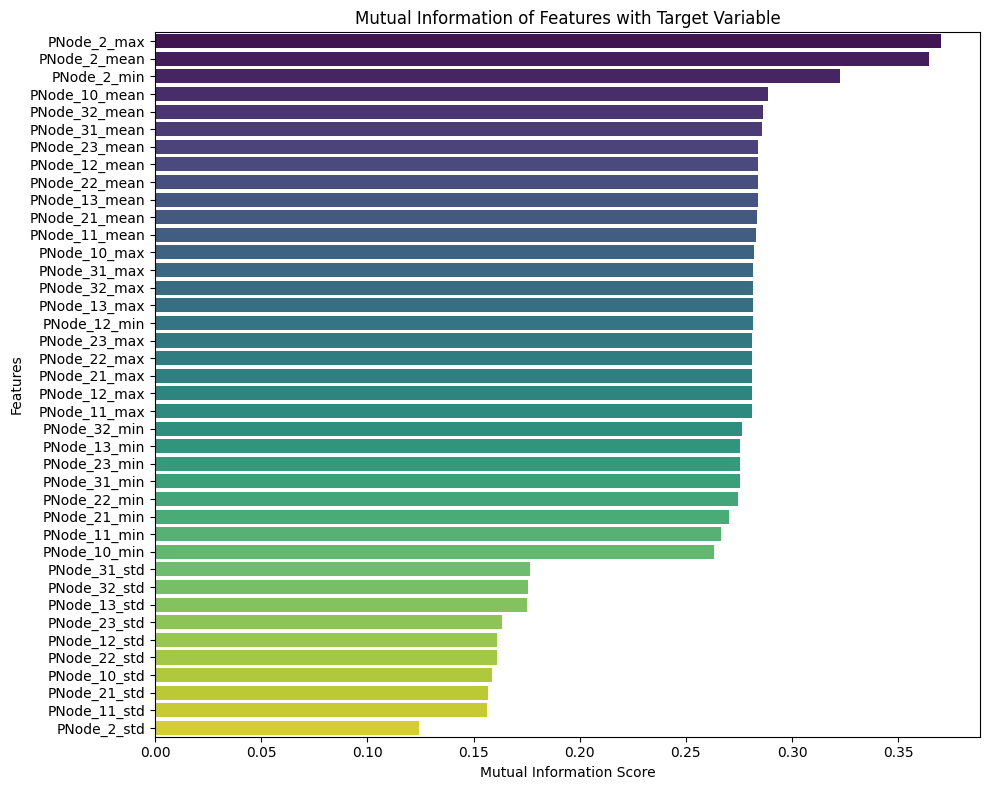

In [8]:

from sklearn.feature_selection import mutual_info_classif


# Assuming df is your DataFrame and 'Label' is your target column
X = df_filtered.drop(columns=['Label'])
y = df_filtered['Label']

# Calculate mutual information between features and the label
mi_scores = mutual_info_classif(X, y, random_state=42)

# Create a DataFrame for the feature names and their mutual information scores
mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information': mi_scores})

# Sort the features by their mutual information scores in descending order
mi_df_sorted = mi_df.sort_values(by='Mutual Information', ascending=False)

# Plot the mutual information scores using a horizontal bar plot
plt.figure(figsize=(10, 8))
sns.barplot(x='Mutual Information', y='Feature', data=mi_df_sorted, palette='viridis')
plt.title('Mutual Information of Features with Target Variable')
plt.xlabel('Mutual Information Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


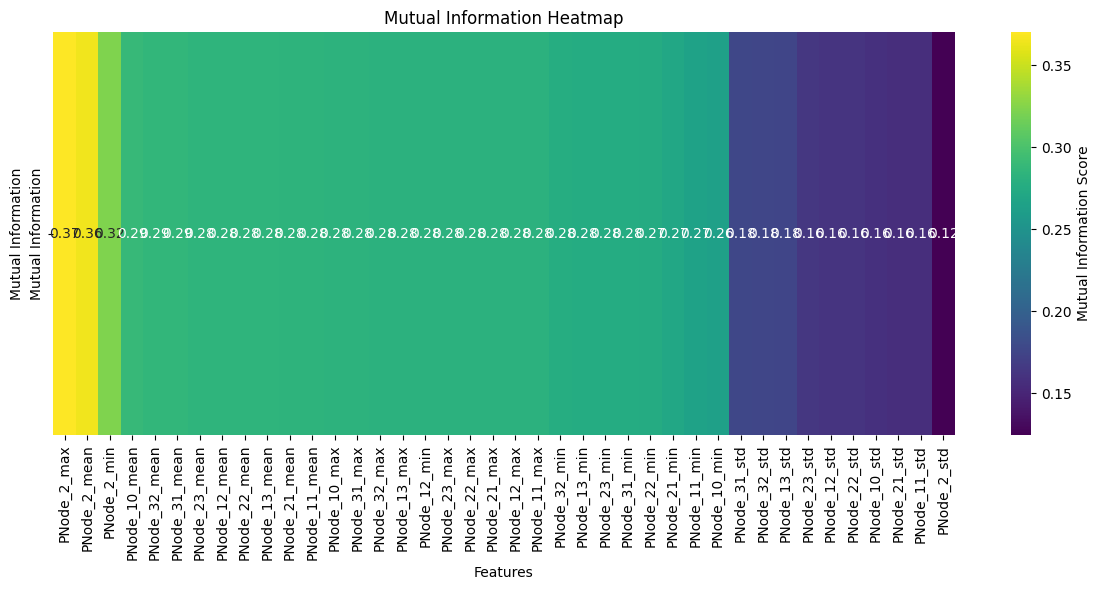

In [12]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and 'Label' is your target column
X = df_filtered.drop(columns=['Label'])
y = df_filtered['Label']

# Calculate mutual information between features and the label
mi_scores = mutual_info_classif(X, y, random_state=42)

# Create a DataFrame for the feature names and their mutual information scores
mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information': mi_scores})

# Sort the features by their mutual information scores in descending order
mi_df_sorted = mi_df.sort_values(by='Mutual Information', ascending=False)

# Set up a heatmap
plt.figure(figsize=(12, 6))
heatmap_data = mi_df_sorted.set_index('Feature').T  # Transpose for heatmap

# Create a heatmap
sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='viridis', cbar_kws={'label': 'Mutual Information Score'})
plt.title('Mutual Information Heatmap')
plt.xlabel('Features')
plt.ylabel('Mutual Information')
plt.tight_layout()
plt.show()


# The end